In [1]:
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.formula.api as smf
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import numpy as np
import pandas as pd
import xarray as xr
import dask
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:40429 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 67.47 GB


In [2]:
r_file = '/home/disk/sipn/nicway/data/Director_data/RPackage/SIPN/mappings_30daylead_2017.rds'

In [3]:
readRDS = robjects.r['readRDS']
df = readRDS(r_file)
df = pandas2ri.ri2py(df)


In [4]:
startYear = df[0][0]
endYear = df[1][0]
print(startYear,endYear)

1.0 364.0


In [5]:
predList = df[2]
predList = [np.array(x) for x in predList]
osbList = df[3]
osbList = [np.array(x) for x in osbList]

In [6]:
# Grab Central region
# year, centlines, info (2=x, 3=y)
da_pred_Cen = xr.DataArray(predList[-1], dims=('years','line','info'), 
                           coords={'years':np.arange(1,predList[-1].shape[0]+1)})
da_obs_Cen = xr.DataArray(osbList[-1], dims=('years','line','info'), 
                           coords={'years':np.arange(1,predList[-1].shape[0]+1)})

In [7]:
rawLength = np.sqrt(da_pred_Cen.isel(info=2)**2 + da_pred_Cen.isel(info=3)**2)
obsLength = np.sqrt(da_obs_Cen.isel(info=2)**2 + da_obs_Cen.isel(info=3)**2)

In [8]:
# Take difference
len_diff = rawLength-obsLength

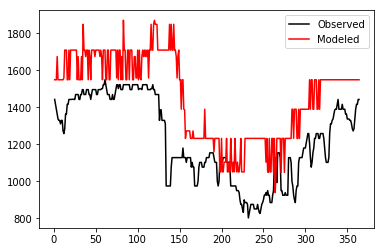

In [9]:
f = plt.figure()
line = 0
plt.plot(obsLength.years, obsLength.isel(line=line),color='k',alpha=1,label='Observed')
plt.plot(rawLength.years, rawLength.isel(line=line),color='r',alpha=1,label='Modeled')
plt.legend()

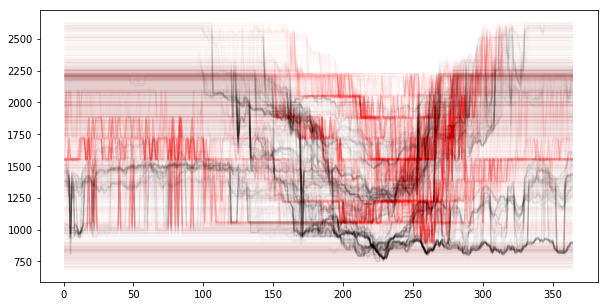

In [10]:
f = plt.figure(figsize=(10,5))
for line in obsLength.line.values:
    plt.plot(obsLength.years, obsLength.isel(line=line),color='k',alpha=0.01)
    plt.plot(rawLength.years, rawLength.isel(line=line),color='r',alpha=0.01)

Text(0.5,0,'Days')

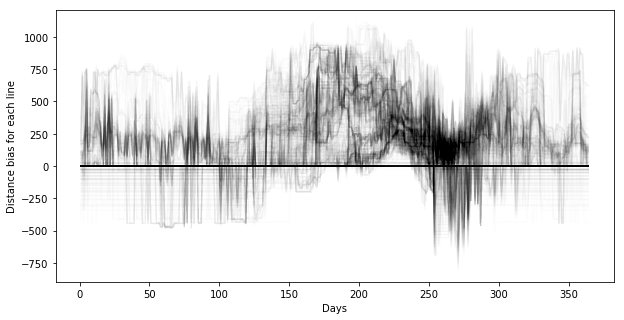

In [11]:
f = plt.figure(figsize=(10,5))
for line in obsLength.line.values:
    plt.plot(obsLength.years, len_diff.isel(line=line) ,color='k',alpha=0.01)
plt.ylabel('Distance bias for each line')
plt.xlabel('Days')

In [12]:
# # What is the auto-corrolation of the model-obs Error for each line?
# lagVal = np.arange(0,len_diff.years.size)

# f = plt.figure(figsize=(10,5))
# for cline in len_diff.line.values:
#     auto1 = [len_diff.isel(line=cline).to_series().autocorr(lag=l) for l in lagVal]
#     plt.plot(lagVal,auto1 ,color='b',alpha=0.01
# plt.ylabel('Pearson Correlation')
# plt.xlabel('Lag in days'

In [13]:
# Define functions

#@dask.delayed
def train_Eval(obsLength= None, rawLength=None, pday=None, 
               leadtime=None, trainPeriod=None, line=None,
              cmodel=None):
    ''' Trains model on defined period of lengths (obs and model). Predicts adjustment, applies it and returns
    DataArray that contains (obs, origmodel, adjusted model) lengths for given line. '''
    # Grab past/observable data
    S = pday-leadtime-trainPeriod
    E = pday-leadtime + 1
    #print("Training ",S,E)

    # Insure S is > 0
    if S<0:
        S=0

    t_obs = obsLength.isel(line=line, years=slice(S,E))
    t_mod = rawLength.isel(line=line, years=slice(S,E))
    # Format in dataframe
    data = t_mod.to_dataframe(name='mod').merge(t_obs.to_dataframe(name='obs'), on='years').reset_index()
    if cmodel=='lm':
        
        # Fit linear models
        lm_mod = smf.ols(formula='mod ~ years', data=data).fit()
        lm_obs = smf.ols(formula='obs ~ years', data=data).fit()
        yo_new = pd.DataFrame({'years': [pday]})

        # Predict day/year
        predsmodel = lm_mod.predict(yo_new)
        predsobs = lm_obs.predict(yo_new)
        # Get difference (potential adjustment to original model)
        preddiff = (predsobs - predsmodel).item()
    elif cmodel=='mean':
        print('mean')
        predsmodel = data['mod'].mean()
        predsobs = data['obs'].mean()
        preddiff = (predsobs - predsmodel)
    else:
        raise ValueError('Model not found.')
        
        
    # Store Obs, Orig, and adjusted lengths in DataArray
    Lobs = obsLength.isel(line=line, years=pday)
    Lorig = rawLength.isel(line=line, years=pday)
    Ladj = Lorig + preddiff
    
    da_out = xr.DataArray([[Lobs,Lorig,Ladj]], dims=('line','source'), 
                                coords={'line':[line],'source':['obs','orig','adj']})
        
    return da_out

@dask.delayed
def testmodelX(obsLength= None, rawLength=None, pday=None, leadtime=None, cmodel='rlm'):
    ''' Trains and evaluates a given model on lengths of vectors for a given prediction date and leadtime'''
    
    tp_l = []
    for trainPeriod in np.arange(2,30,5):
        cline_l = []
        for line in len_diff.line.values:
            
            # Get Predicted Error
            pred_results = train_Eval(obsLength=obsLength, rawLength=rawLength, 
                                  pday=pday, leadtime=leadtime, trainPeriod=trainPeriod,
                                  line=line, cmodel=cmodel)
            
            cline_l.append(pred_results)
                
        error_l = xr.concat(cline_l, dim='line')
        error_l.coords['trainPeriod'] = trainPeriod
        tp_l.append(error_l)
        
    error_tp = xr.concat(tp_l, dim='trainPeriod')
    error_tp.coords['leadtime'] = leadtime
    
    return error_tp

@dask.delayed
def add_coords(da=None, newCoords=None, coordsValue=None):
    da[newCoords] = coordsValue
    return da

In [14]:
# For all prediction days
all_days = []
for pday in np.arange(60,364,15): #obsLength.years.max().values):
    # For all lead times
    output = []
    for lt in [30]: #np.arange(1,43+1,5): This is hardocded by output from R code!!!!
        c_Error = testmodelX(obsLength= obsLength, 
                             rawLength=rawLength, 
                             pday=pday, 
                             leadtime=lt, cmodel='mean')
        output.append(c_Error)

    cday_total = dask.delayed(xr.concat)(output, dim='leadtime')
    cday_total = add_coords(da=cday_total, newCoords='pday', coordsValue=pday)
    all_days.append(cday_total)
    
all_out = dask.delayed(xr.concat)(all_days, dim='pday')

In [15]:
# all_out.visualize(optimize_graph=True,filename='daskgraph.png')  

In [16]:
%time da_lens = all_out.compute()

CPU times: user 20.3 s, sys: 3.8 s, total: 24.1 s
Wall time: 2min 15s


In [17]:
da_lens.sel(source='obs').mean()

<xarray.DataArray ()>
array(1495.950149)
Coordinates:
    source   <U4 'obs'

In [18]:
da_lens.sel(source='orig').mean()

<xarray.DataArray ()>
array(1604.109997)
Coordinates:
    source   <U4 'orig'

In [19]:
da_lens.sel(source='adj').mean()

<xarray.DataArray ()>
array(1495.830097)
Coordinates:
    source   <U4 'adj'

In [20]:
#da_lens.to_netcdf('/home/disk/sipn/nicway/data/Director_data/RPackage/SIPN/mapping_errors_365day.nc')

In [21]:
da_lens.pday

<xarray.DataArray 'pday' (pday: 21)>
array([ 60,  75,  90, 105, 120, 135, 150, 165, 180, 195, 210, 225, 240, 255,
       270, 285, 300, 315, 330, 345, 360])
Coordinates:
  * pday     (pday) int64 60 75 90 105 120 135 150 165 180 195 210 225 240 ...

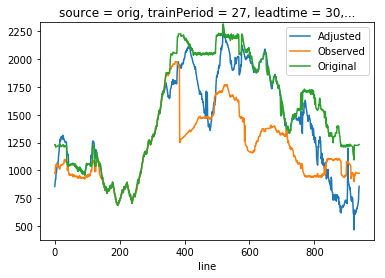

In [22]:
# Check one day
cpday = 195
TP = 27
da_lens.sel(trainPeriod=TP,pday=cpday,leadtime=30).sel(source='adj').plot(label='Adjusted')
da_lens.sel(trainPeriod=TP,pday=cpday,leadtime=30).sel(source='obs').plot(label='Observed')
da_lens.sel(trainPeriod=TP,pday=cpday,leadtime=30).sel(source='orig').plot(label='Original')
plt.legend()

In [23]:
da_lens.trainPeriod

<xarray.DataArray 'trainPeriod' (trainPeriod: 6)>
array([ 2,  7, 12, 17, 22, 27])
Coordinates:
  * trainPeriod  (trainPeriod) int64 2 7 12 17 22 27

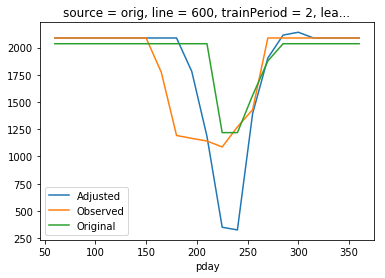

In [24]:
# Check one line
line_1 = 600
TP = 2
da_lens.sel(trainPeriod=TP,line=line_1,leadtime=30).sel(source='adj').plot(label='Adjusted')
da_lens.sel(trainPeriod=TP,line=line_1,leadtime=30).sel(source='obs').plot(label='Observed')
da_lens.sel(trainPeriod=TP,line=line_1,leadtime=30).sel(source='orig').plot(label='Original')
plt.legend()

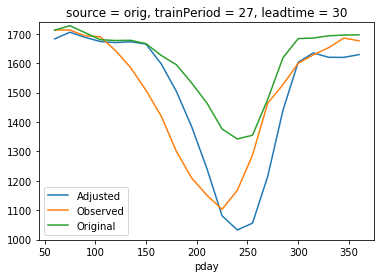

In [25]:
# Plot Error in time 
TP = 27
da_lens.sel(trainPeriod=TP,leadtime=30).mean(dim='line').sel(source='adj').plot(label='Adjusted')
da_lens.sel(trainPeriod=TP,leadtime=30).mean(dim='line').sel(source='obs').plot(label='Observed')
da_lens.sel(trainPeriod=TP,leadtime=30).mean(dim='line').sel(source='orig').plot(label='Original')
plt.legend()

In [26]:
da_lens.dims

('pday', 'leadtime', 'trainPeriod', 'line', 'source')

In [27]:
# Error
orig_err = (da_lens.sel(source='orig') - da_lens.sel(source='obs')) #.sel(trainPeriod=27,leadtime=30)
adj_err = (da_lens.sel(source='adj') - da_lens.sel(source='obs')) #.sel(trainPeriod=27,leadtime=30)
adj_err.dims

('pday', 'leadtime', 'trainPeriod', 'line')

In [28]:
# Bias
print("orig bias", orig_err.mean(['pday', 'leadtime','line']).values)
print("adj bias", adj_err.mean(['pday', 'leadtime','line']).values)

orig bias [108.15984781 108.15984781 108.15984781 108.15984781 108.15984781
 108.15984781]
adj bias [-0.04310634  0.04386608 -0.43403797 -0.45117001  0.08129707  0.08284265]


In [29]:
# RMSE
orig_rmse =   xr.ufuncs.sqrt((orig_err**2).mean(['pday', 'leadtime','line']))
adj_rmse =   xr.ufuncs.sqrt((adj_err**2).mean(['pday', 'leadtime','line']))
print("orig rmse ",orig_rmse.values)
print("adj rmse ", adj_rmse.values)

orig rmse  [241.80857089 241.80857089 241.80857089 241.80857089 241.80857089
 241.80857089]
adj rmse  [214.66563177 220.0063965  223.92452203 227.72548473 231.36032946
 234.03629715]


In [30]:
da_lens.sel(source='orig')

<xarray.DataArray (pday: 21, leadtime: 1, trainPeriod: 6, line: 939)>
array([[[[1709.18238 , ..., 1709.18238 ],
         ...,
         [1709.18238 , ..., 1709.18238 ]]],


       ...,


       [[[1548.854353, ..., 1548.854353],
         ...,
         [1548.854353, ..., 1548.854353]]]])
Coordinates:
    source       <U4 'orig'
  * line         (line) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 ...
  * trainPeriod  (trainPeriod) int64 2 7 12 17 22 27
  * leadtime     (leadtime) int64 30
  * pday         (pday) int64 60 75 90 105 120 135 150 165 180 195 210 225 ...

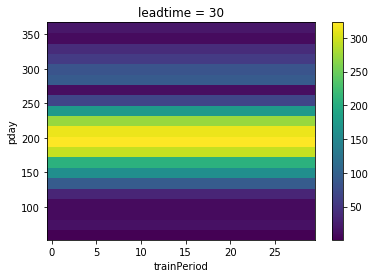

In [31]:
abs(orig_err.mean(dim='line')).plot()

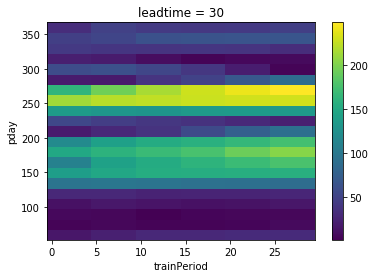

In [32]:
abs(adj_err.mean(dim='line')).plot()

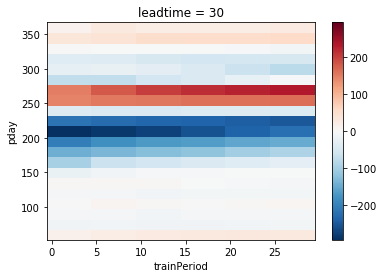

In [33]:
# Where (pday and trainPreiod?) does the adjusted model do better?
(abs(adj_err.mean(dim='line')) - abs(orig_err.mean(dim='line'))).plot()

In [34]:
# get improvement for a given day
TEMP = (abs(adj_err.mean(dim='line')) - abs(orig_err.mean(dim='line')))
TEMP.sel(pday=195)

<xarray.DataArray (leadtime: 1, trainPeriod: 6)>
array([[-204.602226, -181.64131 , -170.599889, -164.425138, -156.344475,
        -148.434421]])
Coordinates:
  * trainPeriod  (trainPeriod) int64 2 7 12 17 22 27
  * leadtime     (leadtime) int64 30
    pday         int64 195

In [35]:
orig_err.mean()

<xarray.DataArray ()>
array(108.159848)

In [36]:
adj_err.mean()

<xarray.DataArray ()>
array(-0.120051)

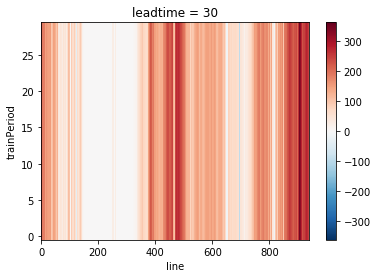

In [37]:
orig_err.mean(dim='pday').plot(label='Original')


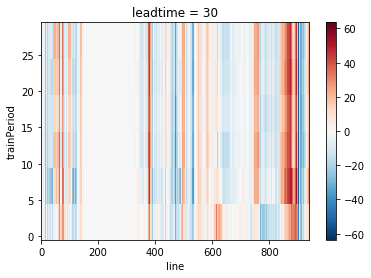

In [38]:
adj_err.mean(dim='pday').plot(label='Adjusted')


In [39]:
# # Average Error Averaged over all lines (all of centeral Arctic)
# agg_E_orig = abs(orig_err.mean(dim='pday').mean(dim='line'))
# agg_E_adj = abs(adj_err.mean(dim='pday').mean(dim='line'))
# agg_E_orig.plot(label='Original')
# agg_E_adj.plot(label='Adjusted')
# plt.legend()
# plt.ylim([np.min([agg_E_orig.min(),agg_E_adj.min()])-5, np.max([agg_E_orig.max(),agg_E_adj.max()])+5])

In [40]:
# # Absolute Error Averaged over all lines (all of centeral Arctic), AND all Leadtimes
# AE_avg.mean(dim='leadtime').plot(label='Adjusted')
# AE_avg_orig.mean(dim='leadtime').plot(label='Original')
# plt.ylabel('Mean Error (distance)')
# plt.title('All Lead times')
# plt.legend()

In [41]:
# What is the best training period to use for all lead times?
#ds_error.trainPeriod.isel(trainPeriod=abs(ds_error).mean(dim=['pday','line','leadtime']).argmin(dim='trainPeriod')).values